In [107]:
#pip3 install numpy pandas scikit-learn tensorflow torch transformers spacy
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, TimeDistributed, Masking
from tensorflow.keras.models import Sequential

In [108]:
#!pip3 install chardet
#!pip3 install datasets

In [109]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')

### Named Entity Recognition (NER) ###
NER is an information extraction technique to identify and classify named entities in text. These entities can be pre-defined and generic like location names, organizations, time and etc, or they can be very specific like the example with the resume.

The goal of a named entity recognition (NER) system is to identify all textual mentions of the named entities. This can be broken down into two sub-tasks: identifying the boundaries of the NE, and identifying its type.

Named entity recognition is a task that is well-suited to the type of classifier-based approach. In particular, a tagger can be built that labels each word in a sentence using the IOB format, where chunks are labelled by their appropriate type.

The IOB Tagging system contains tags of the form:

B - {CHUNK_TYPE} – for the word in the Beginning chunk
I - {CHUNK_TYPE} – for words Inside the chunk
O – Outside any chunk
The IOB tags are further classified into the following classes –

geo = Geographical Entity
org = Organization
per = Person
gpe = Geopolitical Entity
tim = Time indicator
art = Artifact
eve = Event
nat = Natural Phenomenon


prep train data

In [110]:
import os
import chardet
import json
def detect_file_encoding(file_path):
    """Detect the encoding of a file."""
    with open(file_path, 'rb') as f:  # Open in binary mode
        raw_data = f.read()
        result = chardet.detect(raw_data)
        return result['encoding']

def prepare_hf_dataset(parent_folder):
    """Prepare the dataset from all year folders in the given parent folder."""
    dataset = {"tokens": [], "tags": []}
    
    # Iterate over all year folders in the parent folder
    for year_folder in os.listdir(parent_folder):
        year_path = os.path.join(parent_folder, year_folder)
        if os.path.isdir(year_path):  # Check if it's a folder
            for file in os.listdir(year_path):
                if file.endswith(".final"):
                    file_path = os.path.join(year_path, file)
                    # print(f"Processing file: {file_path}")  # Debugging
                    
                    # Detect encoding
                    try:
                        encoding = detect_file_encoding(file_path)
                        # print(f"Detected encoding for {file_path}: {encoding}")
                        with open(file_path, 'r', encoding=encoding) as f:
                            tokens, tags = [], []
                            for line in f:
                                if line.strip():  # Non-empty line
                                    parts = line.strip().split()
                                    if len(parts) == 2:
                                        word, tag = parts
                                        tokens.append(word)
                                        tags.append(tag)
                                else:  # Empty line signals end of a sentence
                                    if tokens and tags:
                                        dataset["tokens"].append(tokens)
                                        dataset["tags"].append(tags)
                                        tokens, tags = [], []  # Reset for next sentence
                            # Ensure the last sentence in the file is added
                            if tokens and tags:
                                dataset["tokens"].append(tokens)
                                dataset["tags"].append(tags)
                    except UnicodeDecodeError as e:
                        print(f"Error processing file {file_path}: {e}")
    
    return dataset

# Test the function
dataset_dir = os.getcwd() + "/Combine_Dataset"
dataset = dict({})

for dir in os.scandir(dataset_dir):
    if dir.is_dir():
        try:
            # Attempt to prepare the dataset for this directory
            dataset[dir.name] = prepare_hf_dataset(f"{dataset_dir}/{str(dir.name)}")
            
            # Save the dataset to a JSON file
            output_file = f"{dir.name}_dataset.json"
            with open(output_file, 'w', encoding='utf-8', errors='replace') as f:
                json.dump(dataset[dir.name], f)
            print(f"Dataset saved to {output_file}")
        
        except UnicodeDecodeError as e:
            print(f"Skipping directory {dir.name} due to encoding issue: {e}")
        except Exception as e:
            print(f"An error occurred with directory {dir.name}: {e}")

Dataset saved to dev_dataset.json
Dataset saved to test_dataset.json
Error processing file D:\Y4 T1\NLP\Project/Combine_Dataset/train\2021\2021-47-2-445-476.final: 'charmap' codec can't decode byte 0x9d in position 342: character maps to <undefined>
Dataset saved to train_dataset.json


In [111]:
import pandas as pd
train_df = pd.read_json("train_dataset.json")
test_df = pd.read_json("test_dataset.json")
dev_df = pd.read_json("dev_dataset.json")

print(f"Train Size: {len(train_df)}")
print(f"Test Size: {len(test_df)}")
print(f"Dev Size: {len(dev_df)}")

def labels_lower_to_upper(df):
    for i, tags in enumerate(df.tags):
        for tag in tags:
            if tag.islower():
                df['tags'][i][tags.index(tag)] = tag.upper()

labels_lower_to_upper(train_df)
labels_lower_to_upper(test_df)
labels_lower_to_upper(dev_df)

Train Size: 503
Test Size: 60
Dev Size: 49


In [112]:
def clean_labels(df):
    for i, tags in enumerate(df.tags):
        for tag in tags:
            if tag.islower():
                df['tags'][i][tags.index(tag)] = tag.upper()
            if len(tag) > 1:
                df['tags'][i][tags.index(tag)] = tag[0]
            if tag=='0':
                df['tags'][i][tags.index(tag)] = 'O'
    
clean_labels(train_df)
clean_labels(test_df)
clean_labels(dev_df)

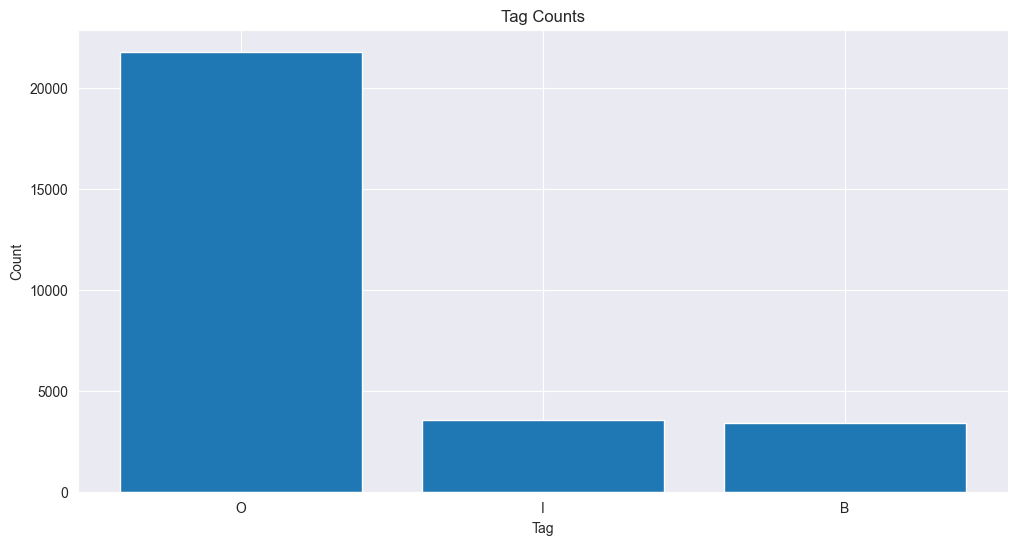

In [113]:
#plot the tags
import matplotlib.pyplot as plt
import numpy

# Count the number of occurrences of each tag
tag_counts = {}
for tags in train_df["tags"]:
    for tag in tags:
        if tag not in tag_counts:
            tag_counts[tag] = 0
        tag_counts[tag] += 1
        
# Sort the tags by count
sorted_tag_counts = dict(sorted(tag_counts.items(), key=lambda x: x[1], reverse=True))

# Plot the tag counts
plt.figure(figsize=(12, 6))
plt.bar(sorted_tag_counts.keys(), sorted_tag_counts.values())
# plt.xticks(rotation=45)
plt.xlabel("Tag")
plt.ylabel("Count")
plt.title("Tag Counts")
plt.show()

In [114]:
# Convert the data into a Hugging Face dataset
from datasets import Dataset
dev_hugging_face_dat = Dataset.from_dict({
    "tokens": dev_df["tokens"],
    "tags": dev_df["tags"]
})

train_hugging_face_dat = Dataset.from_dict({
    "tokens": train_df["tokens"],
    "tags": train_df["tags"]
})

test_hugging_face_dat = Dataset.from_dict({
    "tokens": test_df["tokens"],
    "tags": test_df["tags"]
})

In [115]:
def extract_features(tokens, idx):
    word = tokens[idx]
    features = {
        'word': word,  # Current word
        'is_upper': word.isupper(),  # Is the word uppercase?
        'is_title': word.istitle(),  # Is the word title case?
        'is_digit': word.isdigit(),  # Is the word a digit?
        'word_len': len(word),  # Length of the word
    }
    
    # Previous word features
    if idx > 0:
        features['prev_word'] = tokens[idx - 1]
    else:
        features['prev_word'] = "<START>"
    
    # Next word features
    if idx < len(tokens) - 1:
        features['next_word'] = tokens[idx + 1]
    else:
        features['next_word'] = "<END>"
    
    return features

def prepare_data_for_crf(dataset):
    features = []
    labels = []
    
    for example in dataset:
        tokens = example['tokens']
        tags = example['tags']
        
        # Extract features for each token
        sentence_features = [extract_features(tokens, idx) for idx in range(len(tokens))]
        features.append(sentence_features)
        labels.append(tags)
    
    return features, labels


In [116]:
# Example: Assuming train_dataset is the Hugging Face dataset
train_features, train_labels = prepare_data_for_crf(train_hugging_face_dat)
test_features, test_labels = prepare_data_for_crf(test_hugging_face_dat)


In [117]:

tags=train_df['tags']
tokens=train_df['tokens']

In [118]:
import pandas as pd

def create_sentence_word_tag_pairs(tags_df, tokens_df):
  sentences = []
  for i in range(len(tags_df)):
    tag_list = tags_df.iloc[i]
    token_list = tokens_df.iloc[i]
    sentence = list(zip(token_list, tag_list))
    sentences.append(sentence)
  return sentences

# Assuming your data is in pandas DataFrames named 'tags' and 'tokens'
# Replace 'tags' and 'tokens' with the actual names of your DataFrames

# Create the list of sentences
sentences = create_sentence_word_tag_pairs(tags, tokens)

print(sentences[:2])  # Print the first two sentences

[[('In', 'O'), ('this', 'O'), ('article', 'O'), ('we', 'O'), ('discuss', 'O'), ('several', 'O'), ('metrics', 'B'), ('of', 'I'), ('coherence', 'I'), ('defined', 'O'), ('using', 'O'), ('centering', 'B'), ('theory', 'I'), ('and', 'O'), ('investigate', 'O'), ('the', 'O'), ('usefulness', 'O'), ('of', 'O'), ('such', 'O'), ('metrics', 'B'), ('for', 'O'), ('information', 'O'), ('ordering', 'O'), ('in', 'O'), ('automatic', 'B'), ('text', 'I'), ('generation', 'I'), ('.', 'O')], [('We', 'O'), ('estimate', 'O'), ('empirically', 'O'), ('which', 'O'), ('is', 'O'), ('the', 'O'), ('most', 'O'), ('promising', 'O'), ('metric', 'B'), ('and', 'O'), ('how', 'O'), ('useful', 'O'), ('this', 'O'), ('metric', 'B'), ('is', 'O'), ('using', 'O'), ('a', 'O'), ('general', 'O'), ('methodology', 'O'), ('applied', 'O'), ('on', 'O'), ('several', 'O'), ('corpora', 'B'), ('.', 'O')]]


In [119]:
import pandas as pd

def extract_words_from_dataframe(df):
  all_words = []
  for sentence in df['tokens']:  # Assuming the column name is 'tokens'
    all_words.extend(sentence)
  return all_words

# Assuming your DataFrame is named 'df'
word = extract_words_from_dataframe(train_df) 
print(word)

['In', 'this', 'article', 'we', 'discuss', 'several', 'metrics', 'of', 'coherence', 'defined', 'using', 'centering', 'theory', 'and', 'investigate', 'the', 'usefulness', 'of', 'such', 'metrics', 'for', 'information', 'ordering', 'in', 'automatic', 'text', 'generation', '.', 'We', 'estimate', 'empirically', 'which', 'is', 'the', 'most', 'promising', 'metric', 'and', 'how', 'useful', 'this', 'metric', 'is', 'using', 'a', 'general', 'methodology', 'applied', 'on', 'several', 'corpora', '.', 'Our', 'main', 'result', 'is', 'that', 'the', 'simplest', 'metric', '(', 'which', 'relies', 'exclusively', 'on', 'NOCB', 'transitions', ')', 'sets', 'a', 'robust', 'baseline', 'that', 'cannot', 'be', 'outperformed', 'by', 'other', 'metrics', 'which', 'make', 'use', 'of', 'additional', 'centering', 'based', 'features', '.', 'This', 'baseline', 'can', 'be', 'used', 'for', 'the', 'development', 'of', 'both', 'text', 'to', 'text', 'and', 'concept', 'to', 'text', 'generation', 'systems', 'Current', 'machine

In [120]:
import pandas as pd

def extract_words_from_dataframe(df):
  all_words = []
  for sentence in df['tokens']:  # Assuming the column name is 'tokens'
    all_words.extend(sentence)
  return all_words

def find_unique_words(words):
  return list(set(words))

# Assuming your DataFrame is named 'train_df'
all_words = extract_words_from_dataframe(train_df) 
unique_words = find_unique_words(all_words)

print(unique_words)

['fill', 'evolved', 'Last', 'according', 'allows', 'appendices', 'parsing', 'feasibility', 'rating', 'zero', 'issues', 'post', 'among', 'acoustic', 'separately', 'Spanish', 'mentioned', 'tagger', 'ability', 'performing', 'weight', 'biological', 'Annotated', 'pervasiveness', 'correlated', 'concrete', 'languages', 'XLM', 'status', 'not', 'trees', 'wide', 'associated', 'centered', 'outside', 'extractive', 'impetus', 'include', 'tropical', 'shift', '(', 'propositional', 'substantive', '78.4', 'paid', 'rule', 'clause', 'CNL', 'today', 'against', 'leads', '21.3', 'prevent', 'empirically', 'freezing', 'GloVe', 'constituent', 'correlations', 'failures', 'massive', 'phenomenon', 'cycle', 'boosts', '0.80', 'depending', 'theoretic', 'dependent', 'extract', 'evaluates', 'since', 'detail', 'considered', 'topics', 'if', 'definitions', 'studied', 'rapidly', 'review', 'vertex', 'utilize', 'permutations', 'creates', 'extremely', 'discusses', 'segmented', 'very', 'Integer', '3', 'pivotal', 'order', 'bet

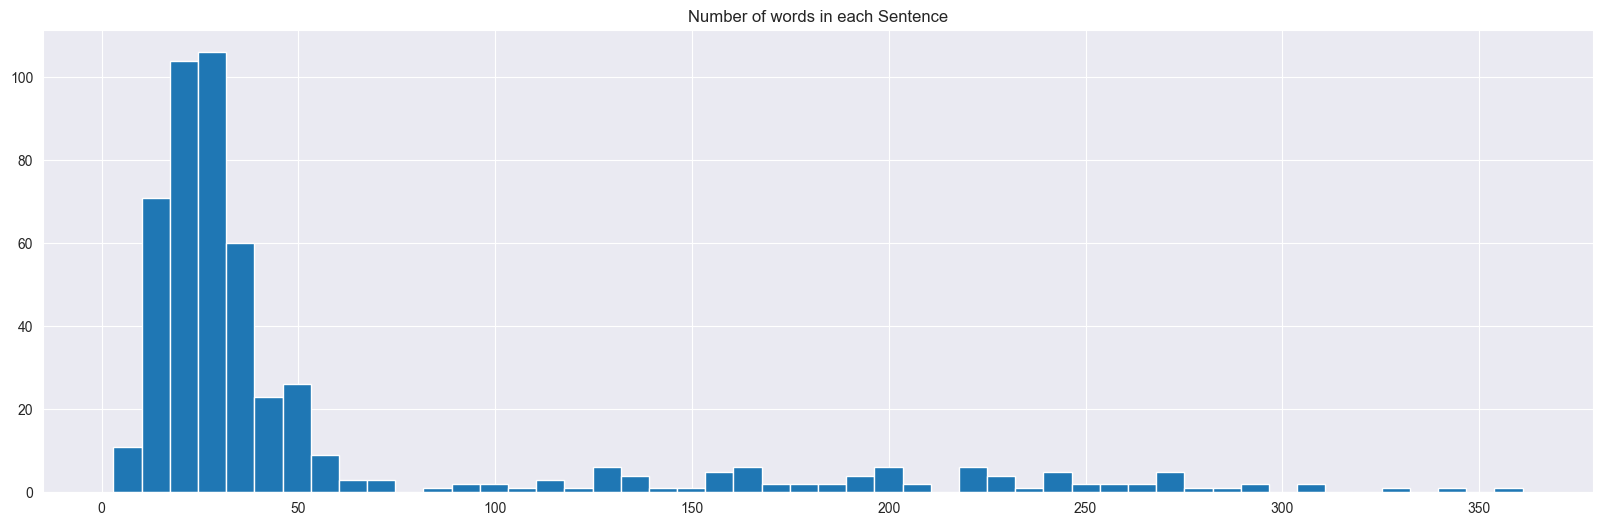

Number of Sentences: 503
Maximum sequence length: 361
Number of unique words: 4013


In [121]:
import matplotlib.pyplot as plt

# Assuming 'sentences' is a list of sentences (where each sentence is a list of words)

# Plot the distribution of sentence lengths
fig, ax = plt.subplots(figsize=(20, 6))
ax.hist([len(s) for s in sentences], bins=50)
ax.set_title('Number of words in each Sentence')
plt.show()

# Find the maximum sentence length
maxlen = max([len(s) for s in sentences])

# Print the number of sentences and maximum sequence length
print('Number of Sentences:', len(sentences))
print ('Maximum sequence length:', maxlen)

# Add a special token for padding
word.append("ENDPAD") 

# Calculate the number of unique words
n_words = len(unique_words)
print('Number of unique words:', n_words)

In [122]:
unique_tags = list(set(tag for tags in train_labels for tag in tags))


In [123]:
tags=(unique_tags)
words=(unique_words)

In [124]:
data = pd.read_json("train_dataset.json")
print(data.shape)
data.head()

(503, 2)


,tokens,tags
0,"[In, this, article, we, discuss, several, metr...","[O, O, O, O, O, O, B, I, I, O, O, B, I, O, O, ..."
1,"[We, estimate, empirically, which, is, the, mo...","[O, O, O, O, O, O, O, O, B, O, O, O, O, B, O, ..."
2,"[Our, main, result, is, that, the, simplest, m...","[O, O, O, O, O, O, O, O, O, O, O, O, O, B, I, ..."
3,"[This, baseline, can, be, used, for, the, deve...","[O, O, O, O, O, O, O, O, O, O, B, I, I, O, B, ..."
4,"[Current, machine, translation, (, MT, ), syst...","[O, B, I, O, B, O, O, O, O, O, O, O]"


#### Converting words to numbers and numbers to words



In [125]:
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

## RNN Modelling

In [126]:
#!pip3 install tensorflow

In [127]:
from keras.models import Sequential
from keras.layers import Input, Embedding,TimeDistributed, LSTM, Dropout, Bidirectional, Dense 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.utils import plot_model, to_categorical
import numpy as np


In [128]:
X = [[word2idx[w[0]] for w in s] for s in sentences]
X = sequence.pad_sequences(maxlen=maxlen, sequences=X, padding="post",value=n_words - 1)

n_tags=len(unique_tags)
y = [[tag2idx[w[1]] for w in s] for s in sentences]
y = sequence.pad_sequences(maxlen=maxlen, sequences=y, padding="post", value=tag2idx["O"])
y = np.array([to_categorical(i, num_classes=n_tags) for i in y])

print('X shape', X.shape, 'y shape', y.shape, n_words)

X shape (503, 361) y shape (503, 361, 3) 4013


In [129]:
class config():
    VOCAB = n_words
    MAX_LEN = maxlen
    N_OUPUT = n_tags
    
    
    EMBEDDING_VECTOR_LENGTH = 100
    N_LSTM_CELLS = 64
    RECURRENT_DROPOUT = 0.1
    
    OUTPUT_ACTIVATION = 'softmax'
    
    LOSS = 'categorical_crossentropy'
    OPTIMIZER = 'adam'
    METRICS = ['accuracy']
    
    MAX_EPOCHS = 50

    

In [130]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7)
filepath = "model.keras"
ckpt = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
rlp = ReduceLROnPlateau(monitor='loss', patience=7, verbose=1)

model = Sequential()
model.add(
    Embedding(
        input_dim=config.VOCAB, output_dim=config.EMBEDDING_VECTOR_LENGTH, input_length=config.MAX_LEN
    )
)
model.add(
    Bidirectional(
        LSTM(config.N_LSTM_CELLS, return_sequences=True, recurrent_dropout=config.RECURRENT_DROPOUT)
    )
)
model.add(
    TimeDistributed(
        Dense(config.N_OUPUT, activation=config.OUTPUT_ACTIVATION)
    )
)
model.compile(loss=config.LOSS, optimizer=config.OPTIMIZER, metrics=config.METRICS)

model.summary()


D:\Y3 T8\ML\Labs\Support Vector Machine\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [131]:
history = model.fit(x=X, y=y, validation_split=0.1,
    callbacks=[es, ckpt, rlp], epochs=config.MAX_EPOCHS
)

Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 540ms/step - accuracy: 0.7623 - loss: 0.4308
Epoch 1: loss improved from inf to 0.22918, saving model to model.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 26s 818ms/step - accuracy: 0.7711 - loss: 0.4182 - val_accuracy: 0.9016 - val_loss: 0.3040 - learning_rate: 0.0010
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 506ms/step - accuracy: 0.9676 - loss: 0.1024
Epoch 2: loss improved from 0.22918 to 0.09616, saving model to model.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 516ms/step - accuracy: 0.9677 - loss: 0.1020 - val_accuracy: 0.9016 - val_loss: 0.2997 - learning_rate: 0.0010
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 508ms/step - accuracy: 0.9703 - loss: 0.0838
Epoch 3: loss improved from 0.09616 to 0.08716, saving model to model.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 518ms/step - accuracy: 0.9702 - loss: 0.0841 - val_accuracy: 0.9017 - val_loss: 0.2839 - learning_rate: 0.0010
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 507ms/step - accuracy: 0.9679 - loss: 0.0849
Epoch 4:

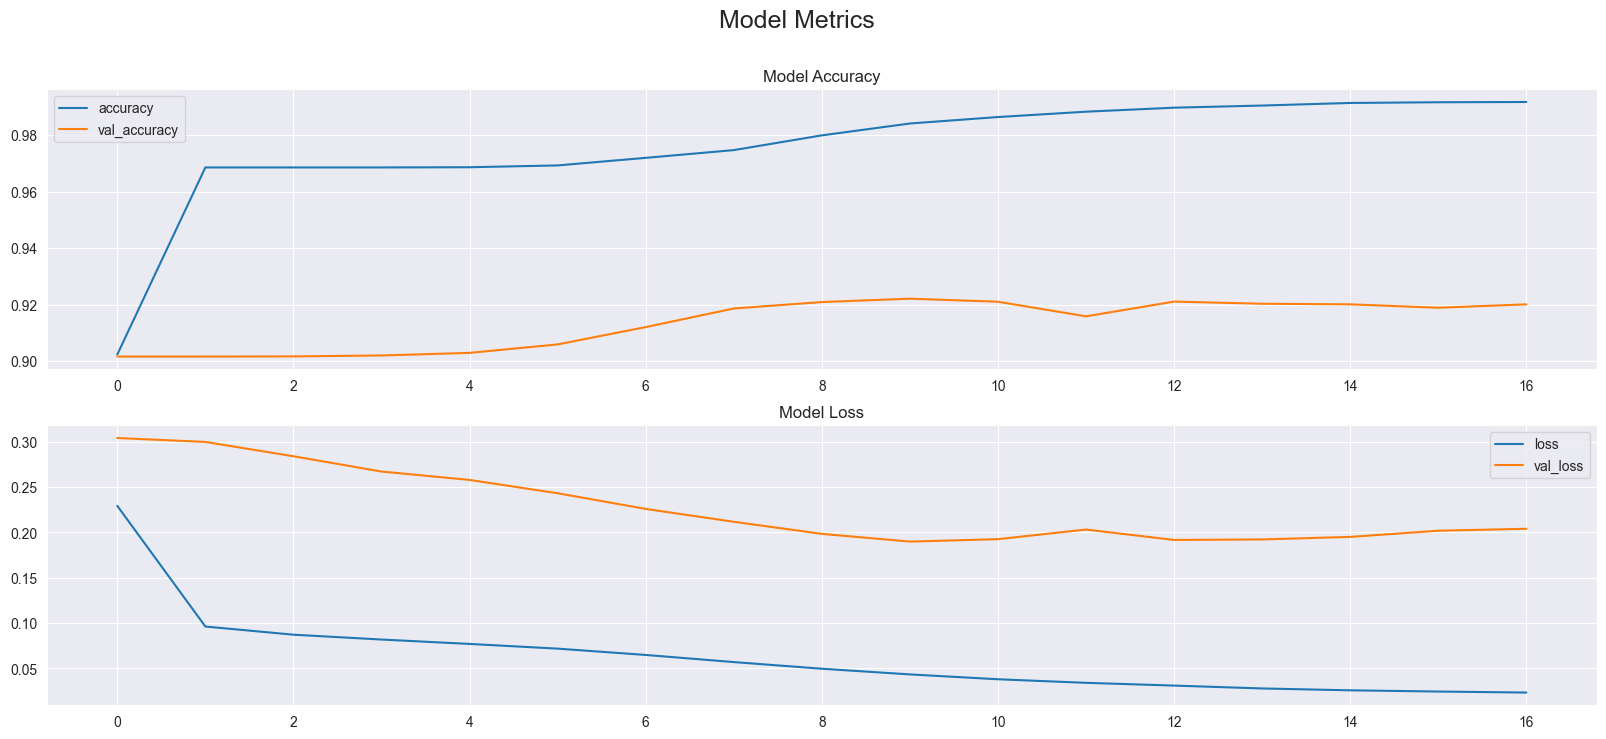

In [132]:
fig, ax = plt.subplots(2, 1, figsize=(20, 8))
df = pd.DataFrame(history.history)
df[['accuracy', 'val_accuracy']].plot(ax=ax[0])
df[['loss', 'val_loss']].plot(ax=ax[1])
ax[0].set_title('Model Accuracy', fontsize=12)
ax[1].set_title('Model Loss', fontsize=12)
fig.suptitle('Model Metrics', fontsize=18);

In [133]:
i = np.random.randint(0, X.shape[0])
p = model.predict(np.array([X[i]]))
p = np.argmax(p, axis=-1)
y_true = np.argmax(y, axis=-1)[i]

print(f"{'Word':15}\t{'Tag':5}\t{'Pred'}")
print("-"*30)
for (w, t, pred) in zip(X[i], y_true, p[0]):
    print(f"{words[w]:15}{tags[t]}\t{tags[pred]}")
    if words[w] == 'ENDPAD': 
        break

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Word           	Tag  	Pred
------------------------------
Text           B	O
style          I	O
transfer       I	I
important      O	O
task           O	B
natural        B	B
language       I	I
generation     I	I
aims           O	I
control        O	O
certain        O	O
attributes     O	O
generated      O	B
text           O	I
politeness     O	I
emotion        O	O
humor          O	O
long           O	B
history        O	O
field          O	O
natural        B	B
language       I	I
processing     I	I
recently       O	O
gained         O	I
significant    O	O
attention      O	B
thanks         O	O
promising      O	O
performance    O	O
brought        O	B
deep           O	B
neural         B	I
models         I	I
article        O	O
present        O	O
systematic     O	B
survey         O	O
research       O	O
neural         B	B
text           I	I
style          I	I
transfer       I	I
spanning       O	I
representative O	I
articles       O	I
neural         B	B
text         

prepare test data

In [134]:
test_tokens = test_df["tokens"]
test_tags = test_df["tags"]

In [135]:
import pandas as pd

def create_sentence_word_tag_pairs(tags_df, tokens_df):
  sentences = []
  for i in range(len(tags_df)):
    tag_list = tags_df.iloc[i]
    token_list = tokens_df.iloc[i]
    sentence = list(zip(token_list, tag_list))
    sentences.append(sentence)
  return sentences

# Assuming your data is in pandas DataFrames named 'test_tags' and 'test_tokens'

# Create the list of sentences
test_sentences = create_sentence_word_tag_pairs(test_tags, test_tokens)

print(test_sentences[:2]) # Print the first two sentences

[[('Systems', 'O'), ('based', 'O'), ('on', 'O'), ('synchronous', 'B'), ('grammars', 'I'), ('and', 'O'), ('tree', 'B'), ('transducers', 'B'), ('promise', 'O'), ('to', 'O'), ('improve', 'O'), ('the', 'O'), ('quality', 'O'), ('of', 'O'), ('statistical', 'B'), ('machine', 'I'), ('translation', 'I'), ('output', 'I'), (',', 'O'), ('but', 'O'), ('are', 'O'), ('often', 'O'), ('very', 'O'), ('computationally', 'B'), ('intensive', 'O'), ('.', 'O')], [('The', 'O'), ('complexity', 'B'), ('is', 'O'), ('exponential', 'B'), ('in', 'O'), ('the', 'O'), ('size', 'O'), ('of', 'O'), ('individual', 'O'), ('grammar', 'B'), ('rules', 'I'), ('due', 'O'), ('to', 'O'), ('arbitrary', 'B'), ('re', 'O'), ('orderings', 'O'), ('between', 'O'), ('the', 'O'), ('two', 'O'), ('languages', 'O'), ('.', 'O')]]


In [136]:
import pandas as pd

def extract_words_from_dataframe(df):
  all_words = []
  for sentence in df['tokens']:  # Assuming the column name is 'tokens'
    all_words.extend(sentence)
  return all_words

def find_unique_words(words):
  return list(set(words))

# Assuming your DataFrame is named 'train_df'
all_words = extract_words_from_dataframe(test_df) 
tunique_words = find_unique_words(all_words)

print(tunique_words)

['according', 'some', 'disciplines', 'legacy', 'NP', 'parser', 'related', 'parsing', 'describes', 'cross', 'polysemes', 'issues', 'possible', 'technologies', 'texts', 'art', 'Spanish', 'mentioned', 'binarized', 'ability', 'performing', 'fine', 'developing', 'show', 'aware', 'network', 'attention', 'handcrafted', 'languages', 'annotated', 'covers', 'Hyperedge', 'not', 'without', 'trees', 'wide', 'outside', 'Grammars', 'base', 'tree', 'Classiﬁer', 'include', 'linguistics', '2013', 'systems', 'longer', 'people', 'CFGs', 'best', '(', 'documents', 'beginning', 'gain', 'paid', 'rule', 'special', 'sets', 'The', 'polysemous', 'such', 'require', 'out', 'gender', 'leads', 'against', 'empirically', 'questions', 'decipherment', 'sentence-', 'helped', 'universally', 'goals', 'phenomenon', 'deduction', 'researchers', 'algorithms', 'incorporating', 'depending', 'derive', 'high', 'since', 'administration', 'more', 'a', 'need', 'topics', 'detail', 'focus', 'sentiment', 'date', 'goal', 'survey', 'defini

In [137]:
tunique_tags = list(set(tag for tags in test_labels for tag in tags))

In [138]:
word2idxt = {w: i for i, w in enumerate(tunique_words)}
tag2idxt = {t: i for i, t in enumerate(tunique_tags)}

In [139]:
print(tunique_tags)

['O', 'B', 'I']


In [140]:
n_twords = len(tunique_words)

In [141]:
#def prepare_test_data(test_sentences, maxlen, word2idx, tag2idx, n_twords, n_tags, unk_token="<UNK>"):
def prepare_test_data(test_sentences, maxlen, word2idxt, tag2idxt, n_twords, n_tags):
  X_test = [[word2idxt.get(w[0], n_twords - 1) for w in s] for s in test_sentences]
  X_test = pad_sequences(maxlen=maxlen, sequences=X_test, padding="post", value=n_twords - 1)

  y_test = [[tag2idxt[w[1]] for w in s] for s in test_sentences]
  y_test = pad_sequences(maxlen=maxlen, sequences=y_test, padding="post", value=tag2idxt["O"]) 
  y_test = [to_categorical(i, num_classes=n_tags) for i in y_test]

  return X_test, np.array(y_test)

plot confusion

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step

Classification Report:
               precision    recall  f1-score   support

           B       0.17      0.23      0.19       434
           I       0.15      0.19      0.17       463
           O       0.97      0.96      0.96     20763

    accuracy                           0.93     21660
   macro avg       0.43      0.46      0.44     21660
weighted avg       0.94      0.93      0.93     21660



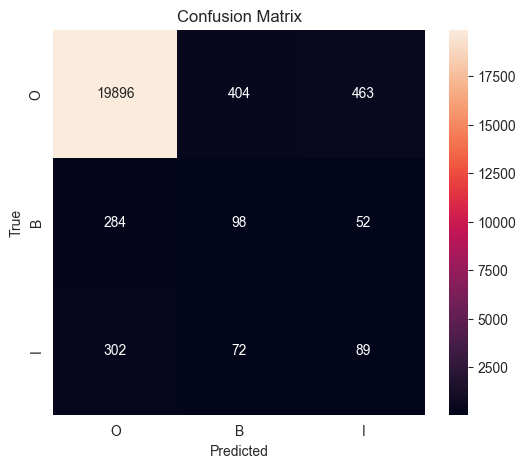

In [142]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

def evaluate_model(model, X_test, y_test, tag2idxt):

    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=-1)

    # Flatten true and predicted labels
    y_true_flat = np.argmax(y_test, axis=-1).flatten() 
    y_pred_flat = y_pred_classes.flatten()

    # Remove padding indices (assuming 0 is the padding index for tags)
    #mask = y_true_flat != tag2idx["O"]
    #y_true_flat = y_true_flat[mask]
    #y_pred_flat = y_pred_flat[mask]

    # Convert indices back to tags
    idx2tag = {v: k for k, v in tag2idxt.items()} 
    y_true_tags = [idx2tag[i] for i in y_true_flat]
    y_pred_tags = [idx2tag[i] for i in y_pred_flat]

    # Generate classification report
    report = classification_report(y_true_tags, y_pred_tags)
    print("\nClassification Report:\n", report)

    # Generate and plot confusion matrix
    conf_matrix = confusion_matrix(y_true_tags, y_pred_tags, labels=list(tag2idxt.keys()))
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=list(tag2idxt.keys()), yticklabels=list(tag2idxt.keys()))
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()
    
X_test, y_test = prepare_test_data(test_sentences, maxlen, word2idxt, tag2idxt, n_twords, n_tags)
evaluate_model(model, X_test, y_test, tag2idxt)



In [143]:
# Save the model
model.save("model.keras")
print("Model saved as 'model.keras'")

Model saved as 'model.keras'


In [163]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

def predict_sentence(sentence, model, word2idx, maxlen):
    """
    Predict BIO tags for a given sentence.
    """
    # BIO Tag Mapping
    BIO_MAP = {
        'O': 0,
        'B': 1,
        'I': 2
    }
    
    # Ensure special tokens exist
    word2idx.setdefault("<UNK>", len(word2idx))
    word2idx.setdefault("<PAD>", len(word2idx))

    # Tokenize and index
    words = sentence.split()
    X_test = [[word2idx.get(w, word2idx["<UNK>"]) for w in words]]
    print("Token Indices:", X_test)

    # Pad sequence
    X_test = pad_sequences(
        sequences=X_test,
        maxlen=maxlen,
        padding="post",
        value=word2idx["<PAD>"]
    ).astype('int32')
    print("Padded Input Shape:", X_test.shape)

    # Prediction
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=-1)[0]

    # Map predictions back to BIO tags
    idx2bio = {v: k for k, v in BIO_MAP.items()}
    predicted_tags = [idx2bio.get(tag_idx, "O") for tag_idx in y_pred_classes]

    return list(zip(words, predicted_tags))


In [164]:
# Inspect Embedding Layer Configuration
print("Vocabulary size (word2idx):", len(word2idx))
print("Model Input Dim (Embedding Layer):", model.layers[0].input_dim)

# Get maxlen from the model's input shape
maxlen = model.input_shape[1]  # Assuming the first dimension is batch size
print("Model Expected Sequence Length (maxlen):", maxlen)

# Flatten X_test and find the maximum token index
import numpy as np
max_token_index = np.max(X_test)
print("Max token index in X_test:", max_token_index)


Vocabulary size (word2idx): 4015
Model Input Dim (Embedding Layer): 4013
Model Expected Sequence Length (maxlen): 361
Max token index in X_test: 1223


In [165]:
# Ensure token indices are within input_dim
input_dim = model.layers[0].input_dim
X_test = [[min(w, input_dim - 1) for w in seq] for seq in X_test]

# Pad the sequences to match maxlen
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_test = pad_sequences(
    sequences=X_test,
    maxlen=maxlen,
    padding="post",
    value=word2idx.get("<PAD>", 0)
).astype('int32')

print("Adjusted X_test Shape:", X_test.shape)


Adjusted X_test Shape: (1, 361)


In [166]:
import numpy as np
X_test = np.array(X_test, dtype='int32')

print("X_test dtype:", X_test.dtype)
print("X_test shape:", X_test.shape)


X_test dtype: int32
X_test shape: (1, 361)


In [167]:
import numpy as np

# Select only the first sample if predicting a single sentence
X_test = X_test[0:1]  # Keep only the first row

print("Adjusted X_test dtype:", X_test.dtype)
print("Adjusted X_test shape:", X_test.shape)


Adjusted X_test dtype: int32
Adjusted X_test shape: (1, 361)


In [168]:
# Verify that all token indices are within the embedding layer's input_dim
input_dim = model.layers[0].input_dim

invalid_indices = [(i, token) for i, seq in enumerate(X_test) for token in seq if token >= input_dim]
if invalid_indices:
    print("Found invalid token indices in X_test:", invalid_indices)
else:
    print("All token indices are within valid range.")


All token indices are within valid range.


In [169]:
print("Model Input Shape:", model.input_shape)
print("Final X_test Shape Before Prediction:", X_test.shape)

Model Input Shape: (None, 361)
Final X_test Shape Before Prediction: (1, 361)


In [170]:
# Inspect model embedding layer and input shape
print("Model Input Shape:", model.input_shape)
print("Model Embedding Input Dim:", model.layers[0].input_dim)
print("Model Embedding Input Length:", model.layers[0].output.shape[1])


Model Input Shape: (None, 361)
Model Embedding Input Dim: 4013
Model Embedding Input Length: 361


In [171]:
import tensorflow as tf
import keras

print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)


TensorFlow version: 2.18.0
Keras version: 3.7.0


In [172]:
# Direct model prediction
import numpy as np

# Ensure X_test is valid
X_test = np.array(X_test, dtype='int32').reshape(1, -1)
print("Final X_test shape (explicitly reshaped):", X_test.shape)

# Predict directly using the model
try:
    y_pred = model.predict(X_test)
    print("Prediction successful!")
    print("Prediction output shape:", y_pred.shape)
    print("Sample prediction output:", y_pred[0])
except Exception as e:
    print("Error during direct prediction:", e)


Final X_test shape (explicitly reshaped): (1, 361)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Prediction successful!
Prediction output shape: (1, 361, 3)
Sample prediction output: [[0.14409213 0.5314719  0.32443598]
 [0.105097   0.5884848  0.3064182 ]
 [0.3515114  0.19034415 0.4581445 ]
 ...
 [0.96400326 0.03059003 0.00540665]
 [0.9471456  0.04614522 0.00670914]
 [0.915547   0.07552203 0.008931  ]]


In [173]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

def predict_sentence(sentence, model, word2idx, maxlen):
    """
    Predict BIO tags for a given sentence with heuristic correction.
    """
    BIO_MAP = {0: 'O', 1: 'B', 2: 'I'}
    
    # Tokenize and convert words to indices
    words = sentence.split()
    input_dim = model.layers[0].input_dim
    
    # Validate <UNK> and <PAD> indices
    if "<PAD>" not in word2idx or word2idx["<PAD>"] >= input_dim:
        word2idx["<PAD>"] = input_dim - 1
    if "<UNK>" not in word2idx or word2idx["<UNK>"] >= input_dim:
        word2idx["<UNK>"] = input_dim - 1
    
    X_test = [[min(word2idx.get(w, word2idx.get("<UNK>", 0)), input_dim - 1) for w in words]]
    
    # Pad the sequence
    X_test = pad_sequences(
        sequences=X_test,
        maxlen=maxlen,
        padding="post",
        value=word2idx["<PAD>"]
    ).astype('int32')
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Get the predicted class indices and map them to BIO tags
    y_pred_classes = np.argmax(y_pred, axis=-1)[0]
    predicted_tags = [BIO_MAP.get(tag_idx, 'O') for tag_idx in y_pred_classes[:len(words)]]
    
    # 🛠️ Heuristic Fix for BIO tags
    for i, (word, tag) in enumerate(zip(words, predicted_tags)):
        if tag == 'I' and (i == 0 or predicted_tags[i-1] == 'O'):
            predicted_tags[i] = 'B'
    
    corrected_tags = list(zip(words, predicted_tags))
    
    print("\nCorrected Predicted Tags:")
    for word, tag in corrected_tags:
        print(f"{word}: {tag}")
    
    return corrected_tags


In [174]:
sentence = "Natural Language Processing is fun"
predicted_tags = predict_sentence(sentence, model, word2idx, maxlen)

print("\nSentence:", sentence)
print("Predicted Tags:")
for word, tag in predicted_tags:
    print(f"{word}: {tag}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step

Corrected Predicted Tags:
Natural: B
Language: I
Processing: I
is: O
fun: O

Sentence: Natural Language Processing is fun
Predicted Tags:
Natural: B
Language: I
Processing: I
is: O
fun: O


In [175]:
import tensorflow as tf
from tensorflow.keras.models import load_model

# Load with the old version (if possible)
model = load_model('model.keras', compile=False)

# Re-save the model
model.save('model_revised.keras', save_format='keras')


In [98]:
for layer in model.layers:
    print(layer.name, type(layer))


embedding_4 <class 'keras.src.layers.core.embedding.Embedding'>
bidirectional <class 'keras.src.layers.rnn.bidirectional.Bidirectional'>
time_distributed_2 <class 'keras.src.layers.rnn.time_distributed.TimeDistributed'>


In [99]:
for layer in model.layers:
    print(f"Layer Name: {layer.name}")
    print(f"Layer Type: {type(layer)}")
    print(f"Config: {layer.get_config()}")
    print("-" * 50)


Layer Name: embedding_4
Layer Type: <class 'keras.src.layers.core.embedding.Embedding'>
Config: {'name': 'embedding_4', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'input_dim': 4013, 'output_dim': 100, 'embeddings_initializer': {'module': 'keras.initializers', 'class_name': 'RandomUniform', 'config': {'seed': None, 'minval': -0.05, 'maxval': 0.05}, 'registered_name': None}, 'embeddings_regularizer': None, 'activity_regularizer': None, 'embeddings_constraint': None, 'mask_zero': False}
--------------------------------------------------
Layer Name: bidirectional
Layer Type: <class 'keras.src.layers.rnn.bidirectional.Bidirectional'>
Config: {'name': 'bidirectional', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'merge_mode': 'concat', 'layer': {'module': 'keras.layers', 'class_name': 'SimpleRNN', 'config': {'name'